In [47]:
import os
import requests
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

import statsmodels.tsa.api as tsa
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

from api_keys import fmp_api_key as api_key
from API import API

api = API(api_key, period='quarter', limit=52)
res = api.getRatios("AAPL")

display(res)
print(res.dtypes)
print(len(res))

,symbol,date,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceEarningsToGrowthRatio,priceToOperatingCashFlowsRatio
0,AAPL,2008-03-29,2.775171,2.184036,0.329340,0.175053,0.034295,0.057885,0.070884,0.687864,6.967478,16.744392,120.367343,233.908405,105.434932
1,AAPL,2008-06-28,3.036233,2.427533,0.348339,0.186495,0.033807,0.054633,0.067138,0.615992,7.660534,20.138666,140.219216,273.785007,113.788796
2,AAPL,2008-09-27,2.641141,2.159405,0.346928,0.182647,0.028707,0.050949,0.056077,0.831592,5.082772,14.354726,99.762818,194.791873,26.386627
3,AAPL,2008-12-27,2.382801,1.886766,0.347398,0.209108,0.037511,0.070060,0.081484,0.867694,3.330450,7.504404,47.537245,93.386421,19.374626
4,AAPL,2009-03-28,2.461857,1.959494,0.363959,0.204214,0.027870,0.049566,0.058672,0.778495,3.916852,11.665147,79.022902,155.595490,113.225443
5,AAPL,2009-06-27,2.110918,1.615029,0.362600,0.200552,0.025530,0.047474,0.055021,0.859549,4.917349,15.269322,103.580424,204.528517,56.079445
6,AAPL,2009-09-26,2.742482,2.331392,0.366160,0.222188,0.030919,0.052623,0.052852,0.822345,5.176172,16.593119,98.362816,195.164742,52.660479
7,AAPL,2009-12-26,2.545010,2.129190,0.408787,0.301282,0.062641,0.094442,0.116535,0.507660,5.345519,12.191451,56.601102,112.993075,33.073607
8,AAPL,2010-03-27,2.644206,2.129446,0.416698,0.294763,0.053876,0.078123,0.089877,0.450061,5.325628,15.523581,68.169427,136.690346,89.936832
9,AAPL,2010-06-26,2.308032,1.776518,0.390828,0.269682,0.050259,0.075456,0.087390,0.501357,5.643176,15.495729,74.787255,150.728309,50.673389


symbol                             object
date                               object
currentRatio                      float64
quickRatio                        float64
grossProfitMargin                 float64
operatingProfitMargin             float64
returnOnAssets                    float64
returnOnEquity                    float64
returnOnCapitalEmployed           float64
debtEquityRatio                   float64
priceToBookRatio                  float64
priceToSalesRatio                 float64
priceEarningsRatio                float64
priceEarningsToGrowthRatio        float64
priceToOperatingCashFlowsRatio    float64
dtype: object
52


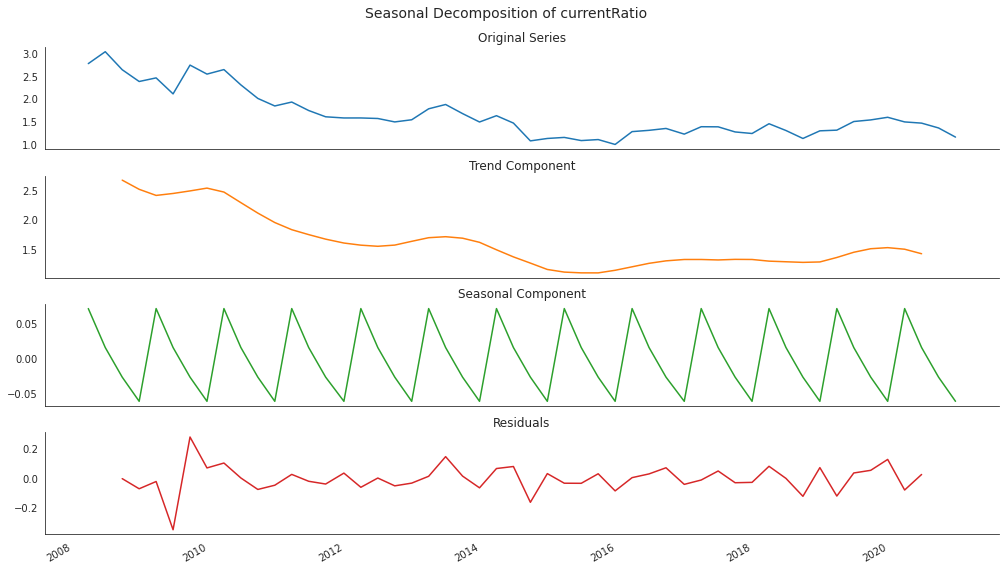

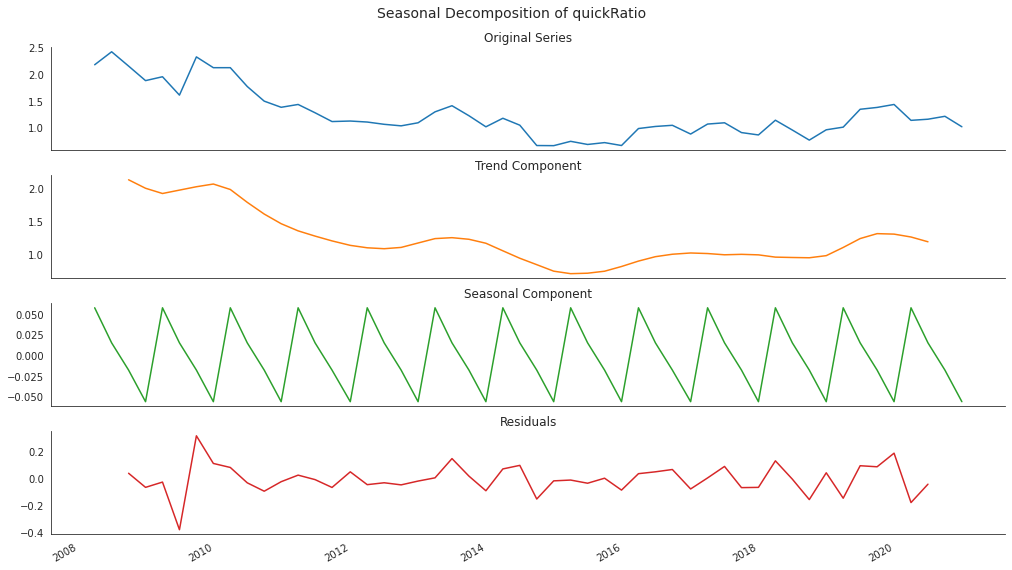

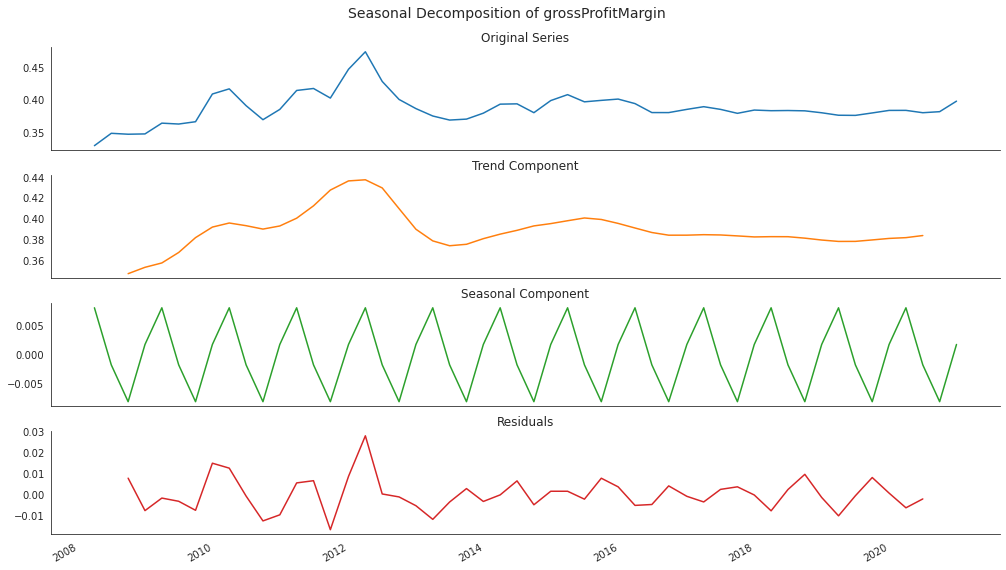

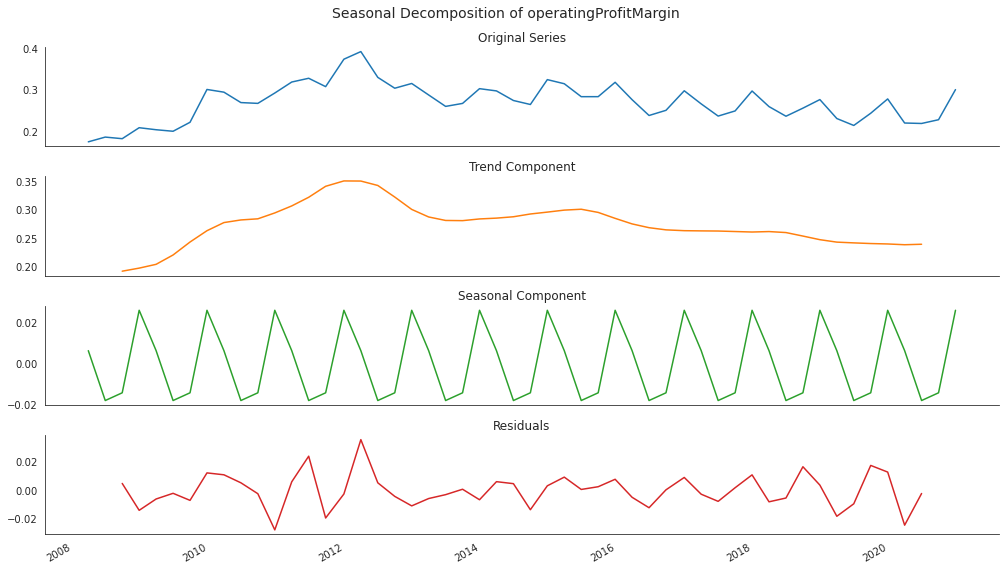

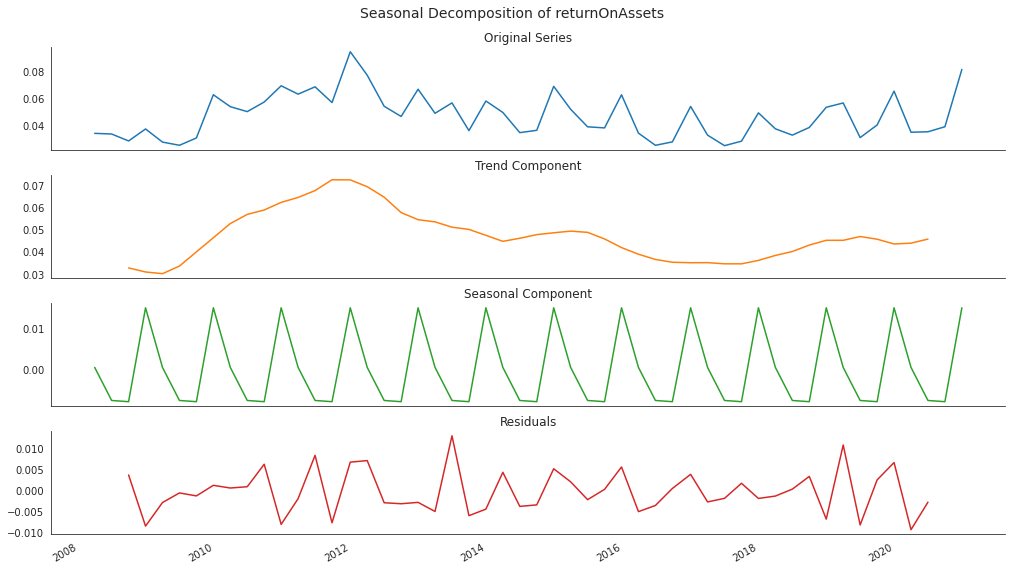

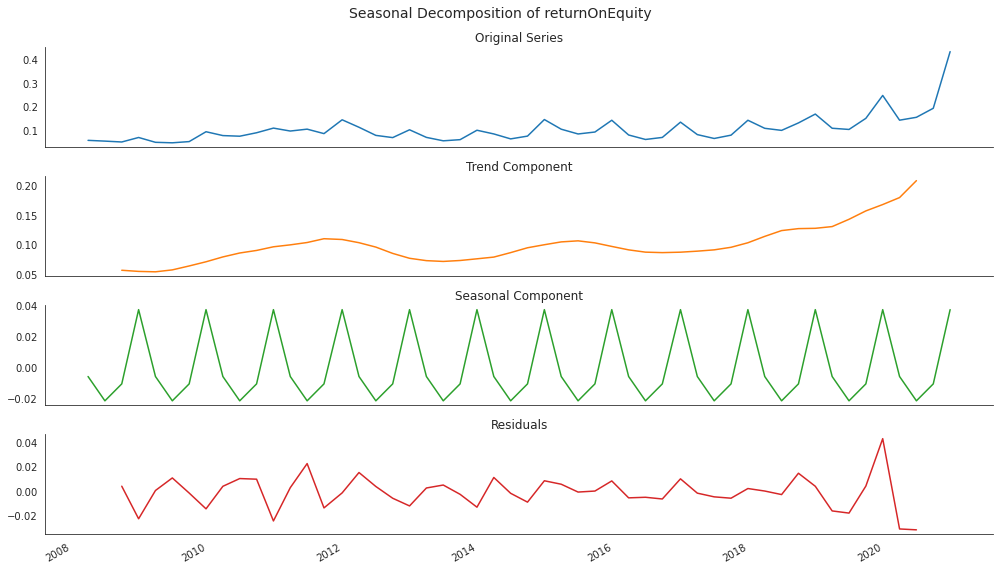

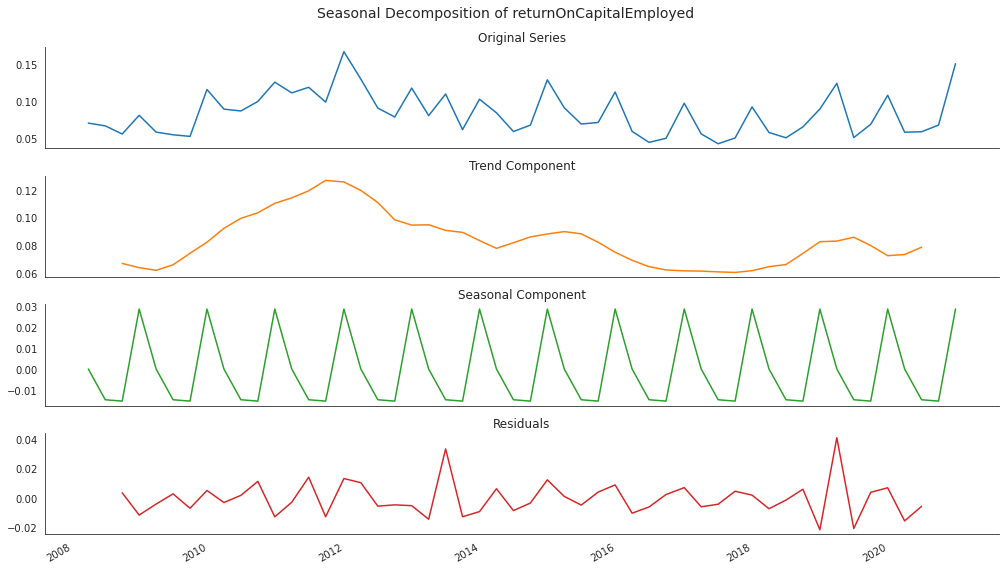

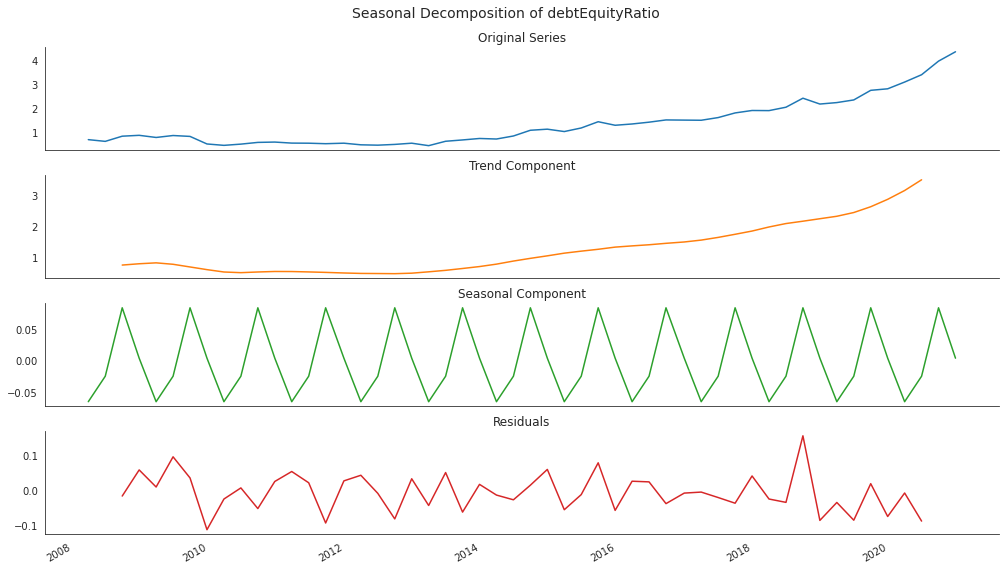

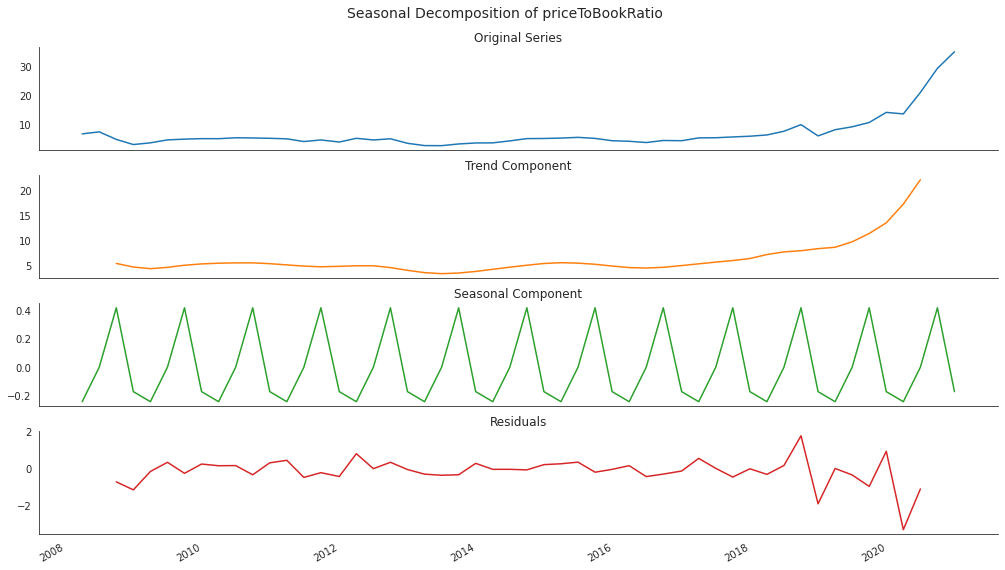

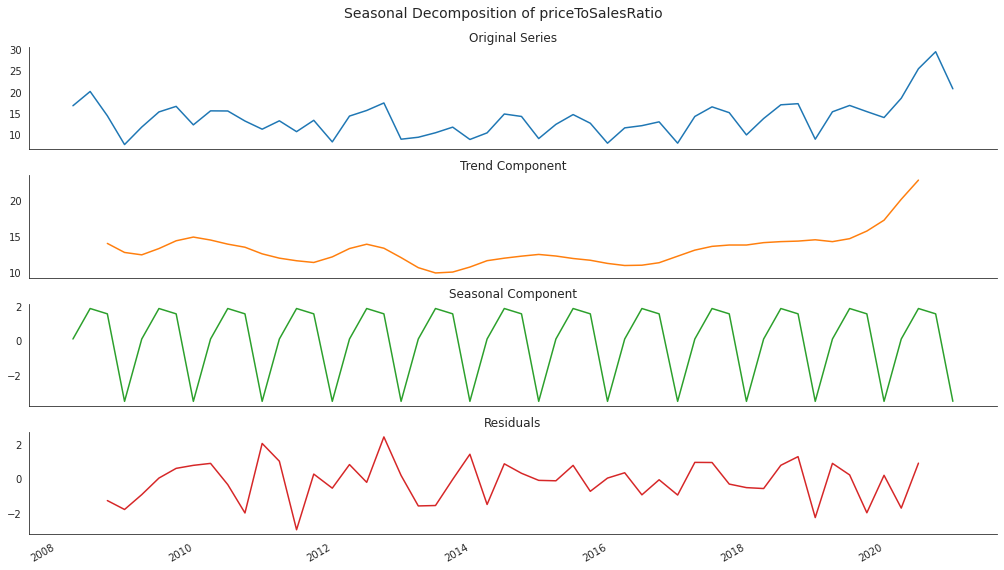

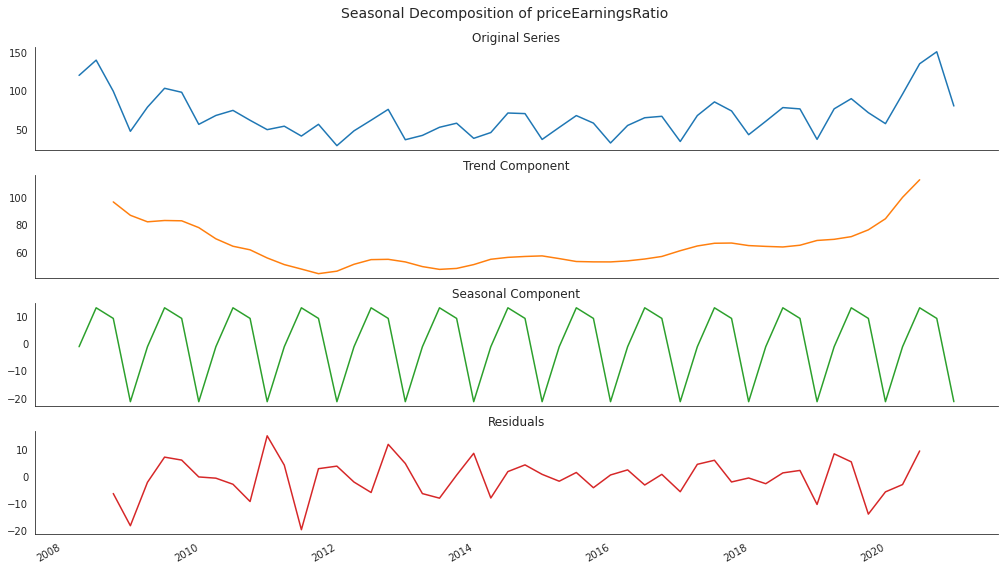

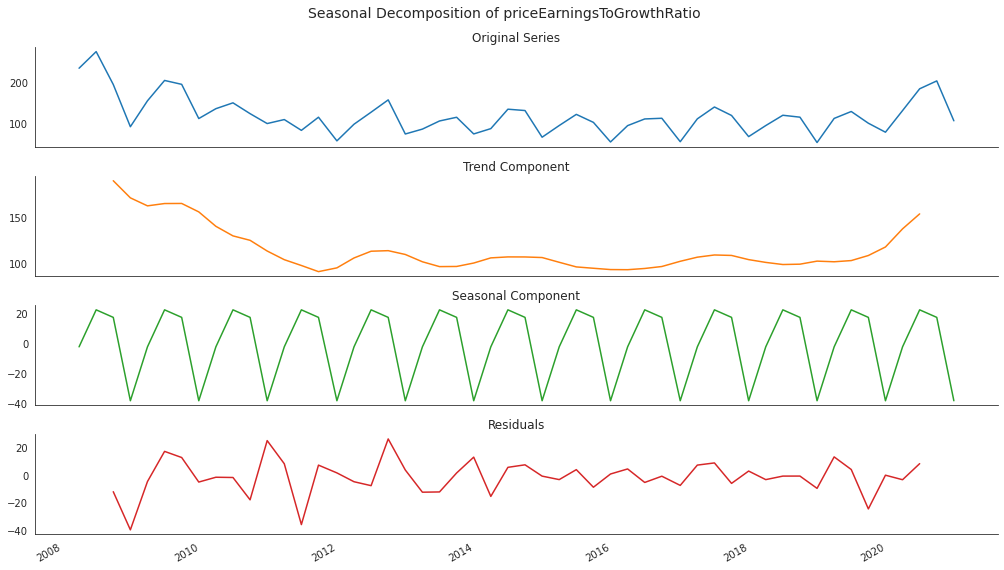

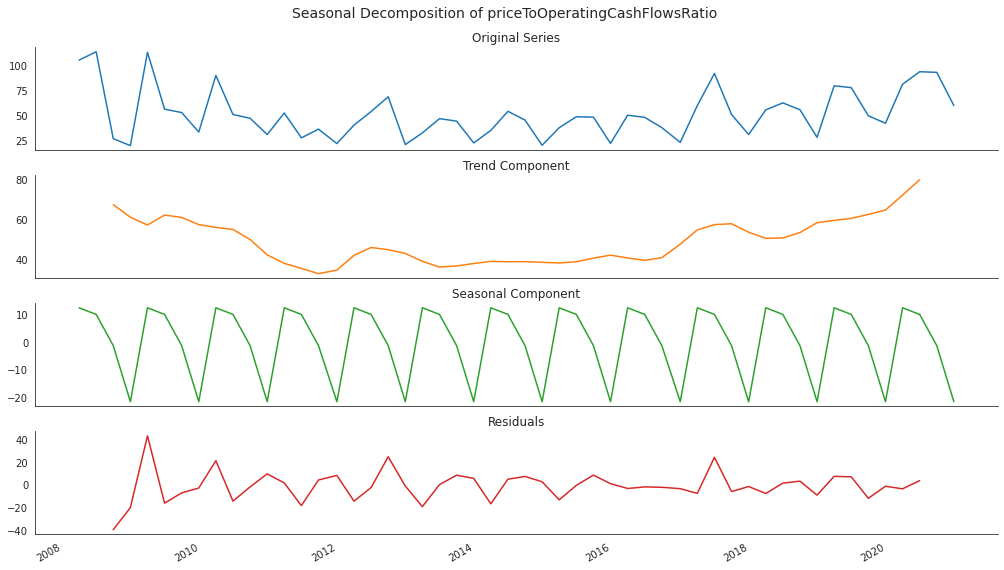

In [53]:
datetime_series = pd.to_datetime(res['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=res.set_index(datetime_index)
df.drop('date',axis=1,inplace=True)
features = [
    "currentRatio", "quickRatio", "grossProfitMargin", "operatingProfitMargin", "returnOnAssets",
    "returnOnEquity", "returnOnCapitalEmployed", "debtEquityRatio", "priceToBookRatio", "priceToSalesRatio",
    "priceEarningsRatio", "priceEarningsToGrowthRatio", "priceToOperatingCashFlowsRatio" 
]
X = pd.DataFrame({})
S = pd.DataFrame({})
for feat in features:
    ratio = df[feat].squeeze().dropna()
    # We predict that the period is annual, thus 4 quarters.
    components = tsa.seasonal_decompose(ratio, model='additive',period=4)
    X[feat] = components.trend.dropna()
    S[feat] = components.seasonal.dropna()
    # Graph the Trend and Seasonal Effects
    ts = (ratio.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
    with sns.axes_style('white'):
        ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
        plt.suptitle('Seasonal Decomposition of ' + feat, fontsize=14)
        sns.despine()
        plt.tight_layout()
        plt.subplots_adjust(top=.91);

In [39]:
# Reduce Dimensionality with PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(StandardScaler().fit_transform(X))
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [36]:
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
print(principalDf)

[49.57 76.94 92.87]
    principal component 1  principal component 2  principal component 3
0                2.840951              -2.457206              -1.612578
1                4.013258              -1.644329              -0.152040
2                4.306409              -1.306729               0.679405
3                4.730739              -0.964174               1.360641
4                5.138008              -0.712964               1.567599
5                5.514318              -0.652174               1.427253
6                5.375250              -0.881644               1.023886
7                4.553449              -1.349414              -0.005391
8                3.783727              -1.622057              -0.883161
9                2.967078              -1.658939              -1.500218
10               2.512160              -1.613619              -1.770699
11               2.409505              -1.520245              -1.073022
12               1.959817              -1.48